<a href="https://colab.research.google.com/github/lherron2/thermomaps-ising/blob/main/thermomaps_ising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
!git clone https://github.com/lherron2/thermomaps-ising.git
%cd thermomaps-ising/thermomaps-root
! pip -q install .
! pip install -qr requirements.txt
%cd -

fatal: destination path 'thermomaps-ising' already exists and is not an empty directory.
/content/thermomaps-ising/thermomaps-root
  Preparing metadata (setup.py) ... done
/content


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from ising.observables import Energy, Magnetization
from ising.samplers import SwendsenWangSampler, SingleSpinFlipSampler
from ising.base import IsingModel

from data.trajectory import EnsembleTrajectory, MultiEnsembleTrajectory
from data.dataset import MultiEnsembleDataset
from data.generic import Summary

from tm.core.prior import GlobalEquilibriumHarmonicPrior, UnitNormalPrior
from tm.core.backbone import ConvBackbone
from tm.core.diffusion_model import DiffusionTrainer, SteeredDiffusionSampler
from tm.core.diffusion_process import VPDiffusion
from tm.architectures.unet_2d_mid_attn import Unet2D


First we simulate the Ising model over a range of temperatures, recording a `trajectory` consisting of lattice configurations. These trajectories are then aggregated into a `MultiEnsembleDataset` (i.e. many trajectories gathered under different thermodynamic ensembles).

In [3]:
trajectories = []
for temperature in np.arange(0.3, 3.5, 0.2):
  IM = IsingModel(sampler=SwendsenWangSampler, size = 8, warmup = 1000, temp = np.round(temperature,1), Jx = 1, Jy = 1)
  IM.simulate(steps = 5000, observables = [Energy(Jx = 1, Jy = 1), Magnetization()], sampling_frequency = 1)
  trajectories.append(IM.trajectory)
dataset = MultiEnsembleDataset(trajectories, Summary())


Each of the trajectories has a `Summary` object attached to it, which is just a `dict` containing metadata about the trajectory. If the summaries associated with all the trajectories in the `MultiEnsembleDataset` all have the same keys, the contents of the `MultiEnsembleDataset` can be conveniently cast as a pandas dataframe.

In [4]:
df = dataset.to_dataframe()
df

,index,name,size,temperature,Jx,Jy,sampler
0,0,IsingModel,8,0.3,1,1,SwendsenWang
1,1,IsingModel,8,0.5,1,1,SwendsenWang
2,2,IsingModel,8,0.7,1,1,SwendsenWang
3,3,IsingModel,8,0.9,1,1,SwendsenWang
4,4,IsingModel,8,1.1,1,1,SwendsenWang
5,5,IsingModel,8,1.3,1,1,SwendsenWang
6,6,IsingModel,8,1.5,1,1,SwendsenWang
7,7,IsingModel,8,1.7,1,1,SwendsenWang
8,8,IsingModel,8,1.9,1,1,SwendsenWang
9,9,IsingModel,8,2.1,1,1,SwendsenWang


The dataframe representation is especially powerful for creating subsets of a `MultiEnsembleDataset`. In this cell we extract a sub-dataframe containing trajectories at temperatures `T=1.5` and `T=2.5`. The sub-dataset can be initialized from the restricted dataframe.

**Our training data is going to be 5,000 samples from two temperatures (total of 10,000 samples) asymetrically spaced about the critical temperature $T_c \approx 2.26$**

In [5]:
sub_df = df[df['temperature'].isin([1.5,2.5])]
sub_dataset = dataset.from_dataframe(sub_df)
sub_df

,index,name,size,temperature,Jx,Jy,sampler
6,6,IsingModel,8,1.5,1,1,SwendsenWang
11,11,IsingModel,8,2.5,1,1,SwendsenWang


Here we extract the relevant observables for the ising model from each temperature in the dataset and plot the distribution of magnetization and energy as a function of temperature.

In [6]:
simulated_M_v_T_mean = {t.state_variables['temperature']: t.observables['magnetization'].quantity.mean() for t in dataset.trajectories}
simulated_E_v_T_mean = {t.state_variables['temperature']: t.observables['energy'].quantity.mean() for t in dataset.trajectories}
simulated_M_v_T_std = {t.state_variables['temperature']: t.observables['magnetization'].quantity.std() for t in dataset.trajectories}
simulated_E_v_T_std = {t.state_variables['temperature']: t.observables['energy'].quantity.std() for t in dataset.trajectories}

train_M_v_T = {traj.state_variables['temperature']: simulated_M_v_T_mean[traj.state_variables['temperature']] for traj in sub_dataset.trajectories}
train_E_v_T = {traj.state_variables['temperature']: simulated_E_v_T_mean[traj.state_variables['temperature']] for traj in sub_dataset.trajectories}

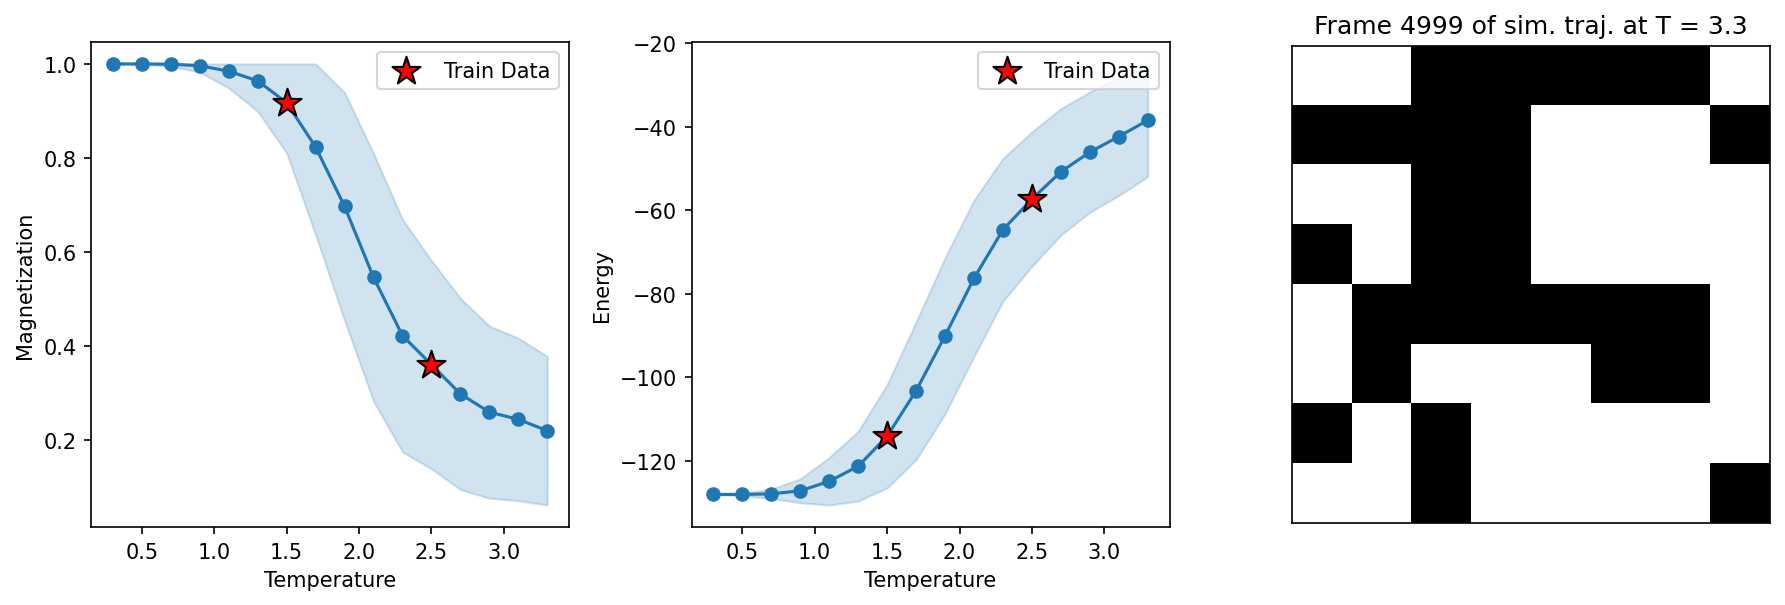

In [7]:
# Vary these to view different trajectories/configurations
trajectory_idx = -1
frame = -1

default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)
ax1.plot(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue)
ax1.scatter(list(train_M_v_T.keys()), list(train_M_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 alpha=0.2, color=default_blue)
ax1.set_ylabel('Magnetization')
ax1.set_xlabel('Temperature')


ax2.plot(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue)
ax2.scatter(list(train_E_v_T.keys()), list(train_E_v_T.values()),
            c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 [m + s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 alpha=0.2, color=default_blue)
ax2.set_ylabel('Energy')
ax2.set_xlabel('Temperature')

img = ax3.imshow(trajectories[-1].coordinates[-1], aspect='equal', cmap='binary')
ax3.set_title(f'Frame {range(len(trajectories[trajectory_idx].coordinates))[frame]} of sim. traj. at T = {trajectories[trajectory_idx].state_variables["temperature"]}')
ax3.set_xticks([])
ax3.set_yticks([])

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()


Loaders for ThermoMap data can also be constructed from a `MultiEnsembleDataset`. The coordinates of the trajectory object are joined with the specified `state_variables` along the channel dimension.

In [8]:
train_loader, test_loader = sub_dataset.to_TMLoader(train_size=0.8, test_size=0.2, state_variables=['temperature'])

Here we initialize the components of the ThermoMap algorithm.

First, we initialize the prior distribution that samples from the dataset will be mapped onto. The `GlobalEquilibriumHarmonicPrior` (`GEHP`) implements the temperature scaling at the core of the ThermoMap algorithm. We view the prior distribution as the equilibrium distribution arising from dynamics of a *physical* prior system. The `GEHP` assumes that the prior system is a particle in a harmonic trap, which results in a Normal equilibrium distribution whose variance is proportional to temperature.

I have also provided a `UnitNormalPrior` (`UNP`) which is a drop-in replacement for the `GEHP` that does not include any temperature rescaling. As such, a ThermoMap trained with a `UNP` is a standard diffusion model.

The prior requires the shape of the training data as input as well as the channels that are associated with coordinates and fluctuations (i.e. temperatures). The coordinate dimensions are sampled from a Normal distribution with variance determined by the fluctuation dimensions, while the fluctuation channels are sampled from a unit Normal distribution.

In [9]:
prior = GlobalEquilibriumHarmonicPrior(shape=train_loader.data.shape, channels_info={"coordinate": [0], "fluctuation": [1]})

The `model` is the black-box that is used to parameterize the score. Here we opt for a 2D U-net with attention at the upsampling/downsampling bottleneck.

In [10]:
model = Unet2D(dim=16, dim_mults=(1, 2, 4), resnet_block_groups=8, channels=2)

The `backbone` is a wrapper around the model which contains the optimizer, scheduler, and other utilities and implements saving and loading the `model`.

In [11]:
backbone = ConvBackbone(model=model,
                        data_shape=train_loader.data_dim,
                        target_shape=8,
                        num_dims=4,
                        lr=1e-3,
                        eval_mode="train")

The `diffusion` instantiates the noise schedule, and implements the forward and reverse transition kernels of the diffusion process. Functionally, the `diffusion` implements the Euler-Maryuma SDE/Euler ODE solver for the variance-preserving diffusion process.

In [12]:
diffusion = VPDiffusion(num_diffusion_timesteps=100)

The `trainer` implements the training algorithm, consisting of sampling noise from the `prior`, calls to the transition kernels of the `diffusion`, and parameterizing the `backbone` to match the score.

In [13]:
trainer = DiffusionTrainer(diffusion,
                           backbone,
                           train_loader,
                           prior,
                           model_dir="/content/models", # save models every epoch
                           pred_type="noise", # set to "noise" or "x0"
                           test_loader=test_loader # optional
                           )

In [14]:
trainer.train(20, loss_type="smooth_l1", batch_size=8)
# Note that the test loss is usually slightly lower than the training loss. This is because
# the training loss is averaged over each epoch (which contains many updates to the weights
# via backprop) while the test loss is evaluated at the end of each epoch. Is there a
# better way to do this? Probably. But it's low priority at the moment.

epoch: 0 | train loss: 0.191 | test loss: 0.123
epoch: 1 | train loss: 0.091 | test loss: 0.083
epoch: 2 | train loss: 0.076 | test loss: 0.078
epoch: 3 | train loss: 0.070 | test loss: 0.068
epoch: 4 | train loss: 0.066 | test loss: 0.073
epoch: 5 | train loss: 0.064 | test loss: 0.063
epoch: 6 | train loss: 0.063 | test loss: 0.061
epoch: 7 | train loss: 0.062 | test loss: 0.063
epoch: 8 | train loss: 0.061 | test loss: 0.062
epoch: 9 | train loss: 0.059 | test loss: 0.064
epoch: 10 | train loss: 0.060 | test loss: 0.063
epoch: 11 | train loss: 0.059 | test loss: 0.061
epoch: 12 | train loss: 0.059 | test loss: 0.063
epoch: 13 | train loss: 0.058 | test loss: 0.061
epoch: 14 | train loss: 0.058 | test loss: 0.057
epoch: 15 | train loss: 0.056 | test loss: 0.059
epoch: 16 | train loss: 0.056 | test loss: 0.057
epoch: 17 | train loss: 0.055 | test loss: 0.056
epoch: 18 | train loss: 0.055 | test loss: 0.056
epoch: 19 | train loss: 0.056 | test loss: 0.061


The `sampler` is similar to the `trainer`, but rather than calling the $p(x_0|x_t)$ kernel, the `sampler` iteratively calls the $p(x_{t-1}|x_t)$ kernel.

In [43]:
sampler = SteeredDiffusionSampler(diffusion,
                                  backbone,
                                  train_loader,
                                  prior,
                                  pred_type='noise', # must be the same as in DiffusionTrainer
                                  )

With our trained model, we generated samples at a range of different temperatures, store the coordinates in an `EnsembleTrajectory` object, and evaluate observables over the coordinates of the trajectory. Note that there is no temporal order between points in the trajectory, as was the case of the Ising simulator.

In [49]:
trajectories = []
pbar = tqdm(np.arange(0.3, 3.5, 0.2))
for temperature in pbar:
  pbar.set_description(f"Generating at T={temperature:.1f}")
  samples = sampler.sample_loop(num_samples=5000, batch_size=5000, temperature=temperature)
  coords = samples[:,0,:,:].numpy() # take coordinate dimension
  # binarize
  coords[coords > 0] = 1
  coords[coords < 0] = -1

  # store in trajectory
  trajectory = EnsembleTrajectory(summary=Summary(info="Generated trajectory"),
                                  state_variables=Summary(temperature=temperature),
                                  coordinates=coords)

  # evaluate observables over trajectory coordinates and add to trajectory object
  energy = Energy()
  energy.evaluate(trajectory.coordinates)

  mag = Magnetization()
  mag.evaluate(trajectory.coordinates)

  trajectory.add_observable(energy)
  trajectory.add_observable(mag)
  trajectories.append(trajectory)

Generating at T=3.3: 100%|██████████| 16/16 [15:11<00:00, 56.98s/it]


In [50]:
generated_M_v_T_mean = {t.state_variables['temperature']: t.observables['magnetization'].quantity.mean() for t in trajectories}
generated_E_v_T_mean = {t.state_variables['temperature']: t.observables['energy'].quantity.mean() for t in trajectories}
generated_M_v_T_std = {t.state_variables['temperature']: t.observables['magnetization'].quantity.std() for t in trajectories}
generated_E_v_T_std = {t.state_variables['temperature']: t.observables['energy'].quantity.std() for t in trajectories}

We find remarkable agreement overlaying the $M(T)$ and $E(T)$ dependence of the ThermoMap-generated and simulated samples.

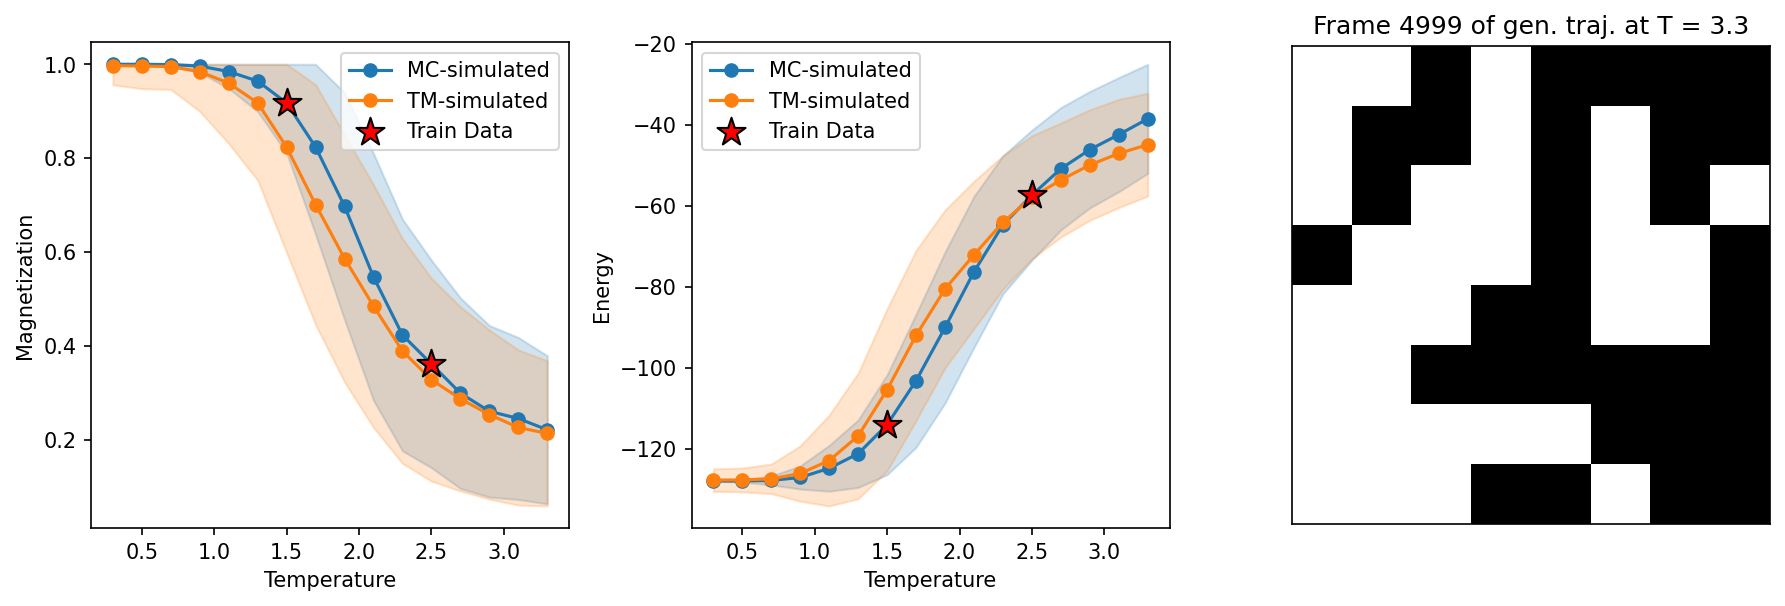

In [51]:
# Vary these to view different trajectories/configurations
trajectory_idx = -1
frame = -1

default_blue = plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
default_orange = plt.rcParams['axes.prop_cycle'].by_key()['color'][1]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4), dpi=150)

# Plot the simulated ising data
ax1.plot(list(simulated_M_v_T_mean.keys()), list(simulated_M_v_T_mean.values()), c=default_blue, marker='o', label="MC-simulated")
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(simulated_M_v_T_mean.values(), simulated_M_v_T_std.values())],
                 alpha=0.2, color=default_blue)

# Plot the generated ising data
ax1.plot(list(generated_M_v_T_mean.keys()), list(generated_M_v_T_mean.values()), c=default_orange, marker='o', label="TM-simulated")
ax1.fill_between(list(simulated_M_v_T_mean.keys()),
                 [max(m - s, 0) for m, s in zip(generated_M_v_T_mean.values(), generated_M_v_T_std.values())],
                 [min(m + s, 1) for m, s in zip(generated_M_v_T_mean.values(), generated_M_v_T_std.values())],
                 alpha=0.2, color=default_orange)

# Plot the training data
ax1.scatter(list(train_M_v_T.keys()), list(train_M_v_T.values()), c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')

ax1.set_ylabel('Magnetization')
ax1.set_xlabel('Temperature')

# Plot the simulated ising data
ax2.plot(list(simulated_E_v_T_mean.keys()), list(simulated_E_v_T_mean.values()), c=default_blue, marker='o', label="MC-simulated")
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 [m + s for m, s in zip(simulated_E_v_T_mean.values(), simulated_E_v_T_std.values())],
                 alpha=0.2, color=default_blue)

# Plot the generated ising data
ax2.plot(list(generated_E_v_T_mean.keys()), list(generated_E_v_T_mean.values()), c=default_orange, marker='o', label="TM-simulated")
ax2.fill_between(list(simulated_E_v_T_mean.keys()),
                 [m - s for m, s in zip(generated_E_v_T_mean.values(), generated_E_v_T_std.values())],
                 [m + s for m, s in zip(generated_E_v_T_mean.values(), generated_E_v_T_std.values())],
                 alpha=0.2, color=default_orange)

# Plot the training data
ax2.scatter(list(train_E_v_T.keys()), list(train_E_v_T.values()), c='r', marker='*', edgecolors='k', s=200, zorder=2, label='Train Data')

ax2.set_ylabel('Energy')
ax2.set_xlabel('Temperature')

img = ax3.imshow(trajectories[trajectory_idx].coordinates[frame], aspect='equal', cmap='binary')
ax3.set_title(f'Frame {range(len(trajectories[trajectory_idx].coordinates))[frame]} of gen. traj. at T = {round(trajectories[trajectory_idx].state_variables["temperature"], 2)}')
ax3.set_xticks([])
ax3.set_yticks([])

ax1.legend()
ax2.legend()
plt.tight_layout()
plt.show()

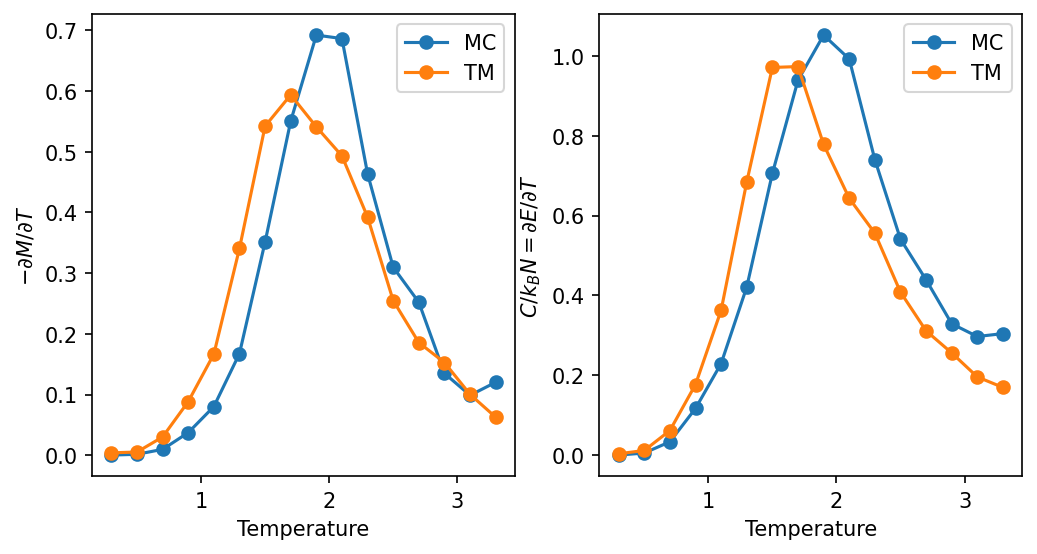

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

ax1.plot(list(simulated_M_v_T_mean.keys()),
        -np.gradient(np.array(list(simulated_M_v_T_mean.values())), list(simulated_M_v_T_mean.keys())),
        c=default_blue, marker='o', label="MC")

ax1.plot(list(generated_M_v_T_mean.keys()),
        -np.gradient(np.array(list(generated_M_v_T_mean.values())), list(generated_M_v_T_mean.keys())),
        c=default_orange, marker='o', label="TM")

ax2.plot(list(simulated_E_v_T_mean.keys()),
        np.gradient(np.array(list(simulated_E_v_T_mean.values()))/8**2, list(simulated_E_v_T_mean.keys())),
        c=default_blue, marker='o', label="MC")

ax2.plot(list(generated_E_v_T_mean.keys()),
        np.gradient(np.array(list(generated_E_v_T_mean.values()))/8**2, list(generated_E_v_T_mean.keys())),
        c=default_orange, marker='o', label="TM")

ax1.set_xlabel("Temperature")
ax1.set_ylabel(fr"$-\partial M/\partial T$")
ax1.legend()

ax2.set_xlabel("Temperature")
ax2.set_ylabel(fr"$C/k_BN = \partial E/\partial T$")
ax2.legend()
